In [1]:
!python mlip_setup_env.py

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 639 (delta 320), reused 276 (delta 195), pack-reused 217
Receiving objects: 100% (639/639), 5.46 MiB | 10.06 MiB/s, done.
Resolving deltas: 100% (393/393), done.
From https://github.com/L-Hess/CS4180-Deep-Learning--CNN
 * [new branch]      master     -> origin/master
Branch 'master' set up to track remote branch 'master' from 'origin'.
Already on 'master'
Changing working directory to code/hw1!
joeran2 2516e9dc7229abc20ce5bfb8c8f92ae6
Data not present, retrieving...
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 84.7MB/s]
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 181MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 158MB/s]
 99% 978M/986M [00:13<00:00, 85.0MB/s]
100% 986M/986M [00:13<00:00, 76.4MB/s]
  0% 0.00/4.72

In [1]:
cd code/hw1

/content/code/hw1


In [0]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

from starter_eda_model_funcs import MultiOutputDataGenerator
from helper import to_one_hot, flow_from_prep, preview_data_aug
from helper import preview_from_prep, train_from_prep
from preprocessing import perform_preprocessing

# further settings
FIG_DIR = 'results/generated_figs/'
plt.rcParams["figure.figsize"] = (10, 4.5) # set higher on 4k monitor
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams["savefig.bbox"] = 'tight'

# Ensemble predictions using models from roi-padding test
Not all models from the runs in Google Colab were saved. Available are:

|    Models   |         |          |               |          |
|:-----------:|:-------:|:--------:|:--------------|:--------:|
| ROI         | Padding | CV split | Saved weights | Run id   |
| 128         | 21      |      0/8 | best, final   | so8bbr9j |
| 96          | 15      |      0/8 | best, final   | ub5tdlzu |
| 32          | 5       |      0/8 | best          | oj3mtm8o |
| ----------- | ------- | -------- | ------------- | -------- |
| 96          | 15      |      1/8 | best, final   | 7vpn5rmy |

<!-- \begin{table}[]
\begin{tabular}{llrll}
\cline{1-3}
\multicolumn{2}{c}{Models} &          &               &          \\ \cline{1-2}
ROI            & Padding   & CV split & Saved weights & Run id   \\ \cline{1-3}
128            & 21        & 0/8      & best, final   & so8bbr9j \\
96             & 15        & 0/8      & best, final   & ub5tdlzu \\
32             & 5         & 0/8      & best          & oj3mtm8o \\
96\_15-cv1/8   & 15        & 1/8      & best, final   & 7vpn5rmy
\end{tabular}
\end{table} -->

## Prepare data sets for roi 128, 96 and 32, for these are required for the predictions


Flowing from Data/prep_32_5/
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.


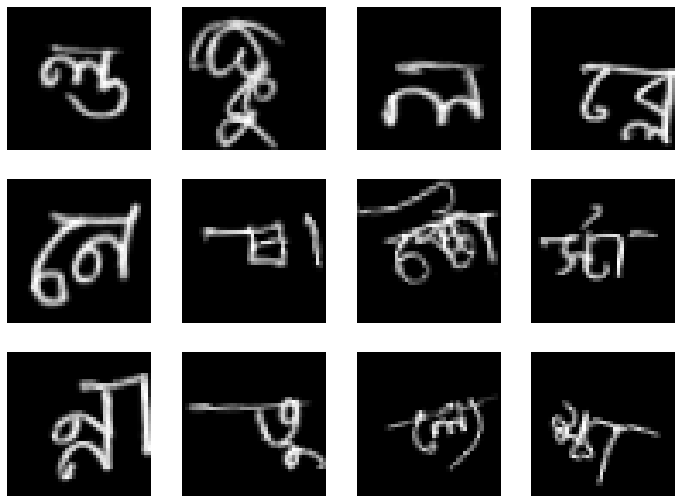


Flowing from Data/prep_96_15/
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.


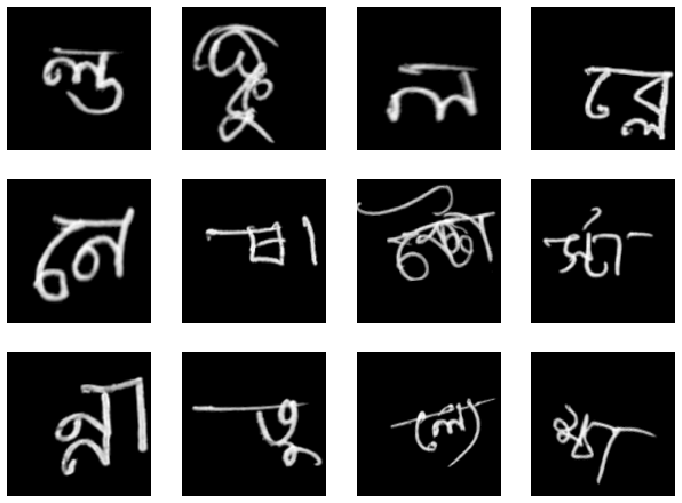


Flowing from Data/prep_128_21/
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.


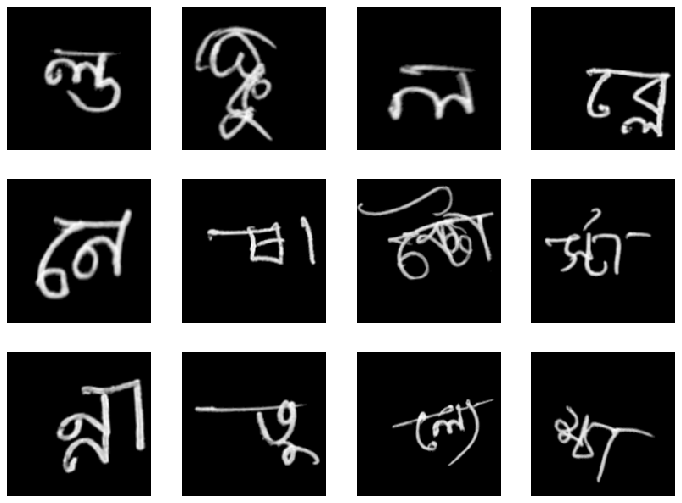

In [4]:
if True:
    datagen_args = dict(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    )

    roi_size_options = [32, 96, 128]
    padding_size_options = [5, 15, 21]

    for roi_size, padding in zip(roi_size_options, padding_size_options):
        preprocess_args = dict(
            image_width=roi_size + padding*2,
            image_height=roi_size + padding*2,
            padding=padding,
        )

        name = f"prep_{roi_size}_{padding}/"
        # perform preprocessing
        perform_preprocessing(preprocess_args, out='png', prep_folder=name)
        # preview preprocessing
        preview_from_prep(preprocess_args, datagen_args, prep_folder=name)

## Fetch models

In [0]:
import wandb
from tensorflow.keras.models import load_model
api = wandb.Api()

roi_options = [32, 96, 128]
pad_options = [ 5, 15,  21]
run_ids     = ['oj3mtm8o', 'ub5tdlzu', 'so8bbr9j']
models      = []
download = True

for roi_size, pad_size, run_id in zip(roi_options, pad_options, run_ids):
    model_fn = f'prep-{roi_size}-{pad_size}-model-best.h5'
    if download:
        run = api.run(f"joeranbosma/mlip/{run_id}")
        run.file("model-best.h5").download()
        os.rename('model-best.h5', model_fn)
    models.append(load_model(model_fn))

## Predict classes of cross-validation split 0
The first part was not seen by any of the models. 

Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


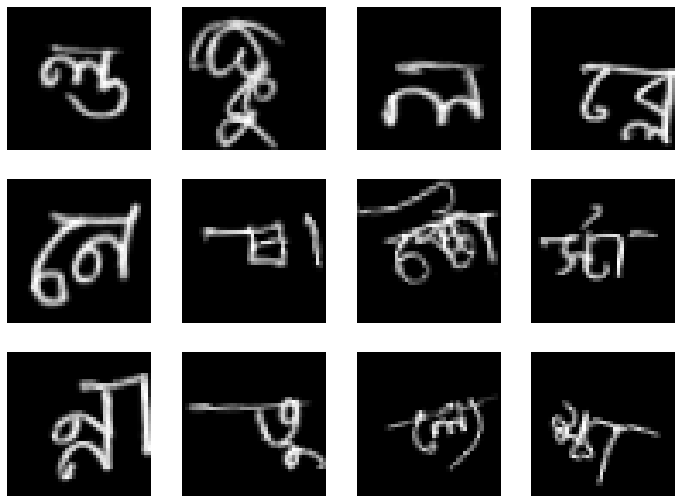

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']

Performance of prep_32_5: 
-- val_acc_global: 0.9611168801784515
-- [0.15304905145752187, 0.23308453, 0.07445638, 0.071570754, 0.9404098, 0.982661, 0.98098695]
-- ['loss', 'out_root_loss', 'out_vowel_loss', 'out_consonant_loss', 'out_root_acc', 'out_vowel_acc', 'out_consonant_acc']

Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


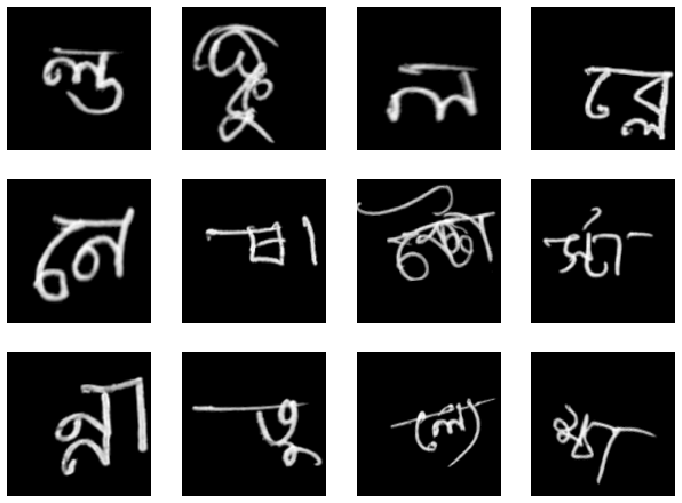

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']

Performance of prep_96_15: 
-- val_acc_global: 0.9714206010103226
-- [0.11562990545466238, 0.17721668, 0.0584617, 0.04962459, 0.9565928, 0.9858897, 0.98660713]
-- ['loss', 'out_root_loss', 'out_vowel_loss', 'out_consonant_loss', 'out_root_acc', 'out_vowel_acc', 'out_consonant_acc']

Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


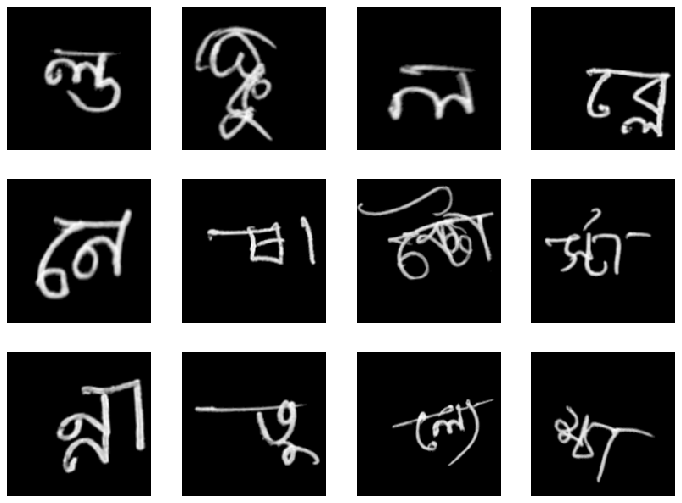

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']

Performance of prep_128_21: 
-- val_acc_global: 0.97216796875
-- [0.11450002068767742, 0.17304745, 0.057262026, 0.054643203, 0.95735013, 0.98768336, 0.98628825]
-- ['loss', 'out_root_loss', 'out_vowel_loss', 'out_consonant_loss', 'out_root_acc', 'out_vowel_acc', 'out_consonant_acc']



In [6]:
from flow import evaluate_trained_model

# set up
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

# cross validation settings
cross_val_num = 0; cross_val_parts = 8

# store results
global_accs, metrics_list, metric_labels = [],[],[]

roi_options = [32, 96, 128]
pad_options = [5, 15, 21]
for roi_size, padding, model in zip(roi_options, pad_options, models):
    preprocess_args = dict(
        image_width=roi_size + padding*2,
        image_height=roi_size + padding*2,
        padding=padding,
    )

    # folders
    data_path='Data/'
    prep_folder = f"prep_{roi_size}_{padding}/"
    name = f"prep_{roi_size}_{padding}"

    # evaluate model
    global_accuracy, metrics, metric_labels = evaluate_trained_model(
                model, datagen_args=datagen_args, preprocess_args=preprocess_args, 
                cross_val_num=cross_val_num, cross_val_parts=cross_val_parts,
                name=name, show_data_aug=True,
                data_path=data_path, prep_folder=prep_folder)
    # print
    print(f"\nPerformance of {name}: \n-- val_acc_global: {global_accuracy}")
    print(f"-- {metrics}\n-- {metric_labels}\n")

    # store
    global_accs.append(global_accuracy)
    metrics_list.append(metrics)

In [7]:
from flow import generators_from_prep
from helper import generator_wrapper

# combine models to an ensemble
y_pred_list = []

for roi_size, padding, model in zip(roi_options, pad_options, models):
    preprocess_args = dict(
        image_width=roi_size + padding*2,
        image_height=roi_size + padding*2,
        padding=padding,
    )
    
    # folders
    data_path='Data/'
    prep_folder = f"prep_{roi_size}_{padding}/"
    name = f"prep_{roi_size}_{padding}"

    # get train and validation generators
    train_generator, val_generator = generators_from_prep(datagen_args=datagen_args, preprocess_args=preprocess_args, 
                         cross_val_num=cross_val_num, cross_val_parts=cross_val_parts, show_data_aug=False,
                         data_path=data_path, prep_folder=prep_folder)
    
    # predict validation set
    val_generator.reset()
    y_preds = model.predict(generator_wrapper(val_generator), verbose=0, 
                            steps=int(np.ceil(val_generator.n / val_generator.batch_size)))
    # need to round up to ensure all validation samples are yielded
    y_pred_list.append(y_preds.copy())

Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


In [10]:
from tensorflow.keras.metrics import categorical_accuracy
y_pred = y_preds[0]
y_true = val_generator.labels[:, :168]
np.mean(categorical_accuracy(y_true, y_pred))

0.957379

In [18]:
from tensorflow.keras.metrics import categorical_accuracy
y_pred_root = np.mean([y_preds[0] for y_preds in y_pred_list], axis=0)
y_pred_vowe = np.mean([y_preds[1] for y_preds in y_pred_list], axis=0)
y_pred_cons = np.mean([y_preds[2] for y_preds in y_pred_list], axis=0)
y_true_root = val_generator.labels[:, :168]
y_true_vowe = val_generator.labels[:, 168:168+11]
y_true_cons = val_generator.labels[:, 168+11:]

acc_root = np.mean(categorical_accuracy(y_pred_root, y_true_root))
acc_vowe = np.mean(categorical_accuracy(y_pred_vowe, y_true_vowe))
acc_cons = np.mean(categorical_accuracy(y_pred_cons, y_true_cons))
acc_glob = acc_root*0.5+acc_vowe*0.25+acc_cons*0.25
print(acc_root, acc_vowe, acc_cons, acc_glob)

0.9640709 0.989285 0.98900616 0.9766082465648651


In [0]:
global_accs.append( acc_glob )

In [20]:
global_accs

[0.9611168801784515, 0.9714206010103226, 0.97216796875, 0.9766082465648651]

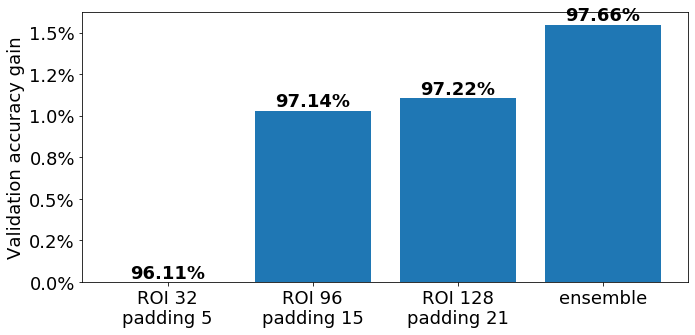

In [24]:
import matplotlib.pyplot as plt
def plot_accuracy_gain(acc, labels, baseline, fn):
    f, axes = plt.subplots(1, 1, figsize=(10, 5))
    ax = axes
    
    # plot bar plot with height the mean and error bars the deviation
    # substract a baseline from all means
    y = acc - acc[baseline]
    ax.bar(range(len(labels)), height=y)
    for i, (v, a) in enumerate(zip(y, acc)):
        ax.text(i, v, f"{a:,.2%}", va='bottom', ha='center', fontweight='bold')

    ax.set_xticklabels(labels)
    ax.set_xticks(range(len(labels)))
    # Set xticks to percentage
    vals = ax.get_yticks()
    # calculate the number of decimals to show without losing information
    num_decimals = int(np.ceil(np.mean(np.abs(np.log10(np.diff(vals)))) - 2))
    labels = ['{x:,.{num}%}'.format(x=x, num=num_decimals) for x in vals]
    ax.set_yticklabels(labels)
    ax.set_ylabel("Validation accuracy gain")

    f.tight_layout()
    f.savefig('{fn}'.format(fn=fn))
    plt.show()

labels = ['ROI 32\npadding 5', 'ROI 96\npadding 15', 'ROI 128\npadding 21', 'ensemble']
plot_accuracy_gain(global_accs, labels=labels, baseline=0, fn='test')

## Test set predictions

### Prepare data!


Flowing from Data/test_32_5/
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 175735 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 0 validated image filenames.


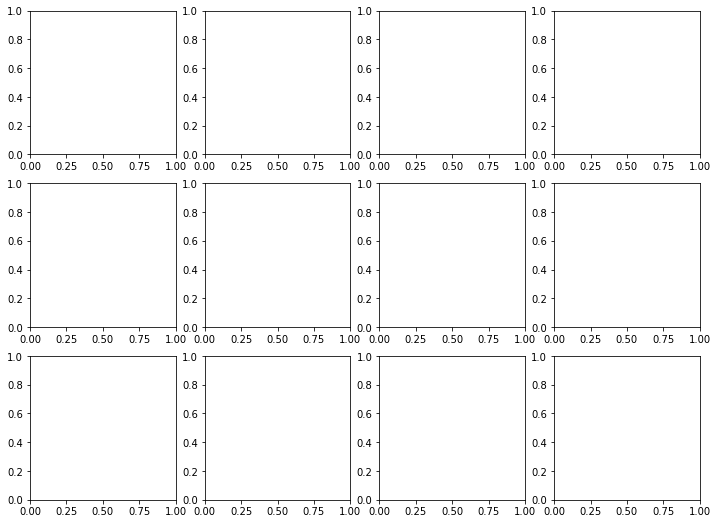


Flowing from Data/test_96_15/
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 0 validated image filenames.


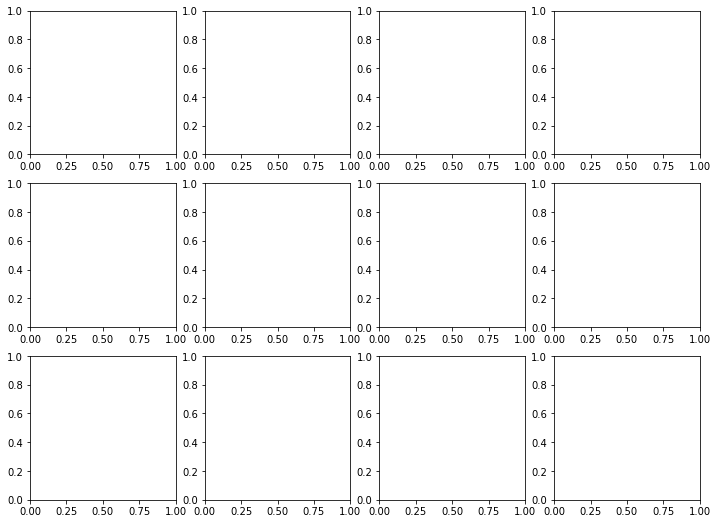


Flowing from Data/test_128_21/
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 0 validated image filenames.


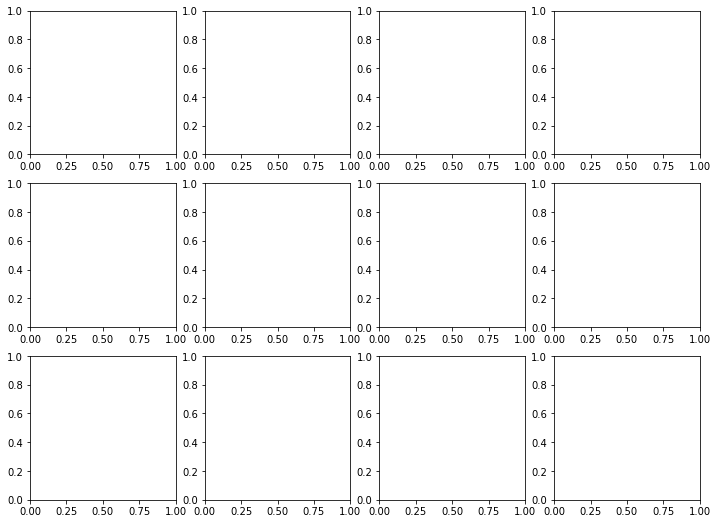

In [5]:
from preprocessing import perform_preprocessing

if True:
    roi_size_options = [32, 96, 128]
    padding_size_options = [5, 15, 21]

    for roi_size, padding in zip(roi_size_options, padding_size_options):
        preprocess_args = dict(
            image_width=roi_size + padding*2,
            image_height=roi_size + padding*2,
            padding=padding,
        )

        name = f"test_{roi_size}_{padding}/"
        # perform preprocessing
        perform_preprocessing(preprocess_args, out='png', prep_folder=name,
                              train_or_test='test')
        # preview preprocessing
        # not working for test set yet
        # preview_from_prep(preprocess_args, datagen_args, prep_folder=name)

In [0]:
# adapted from https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']

target = [] # model predictions placeholder
row_id = [] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('Data/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()